

> In this machine learning project, the focus is on predicting football player market values using data from Sofascore, the world's largest football database. As player prices reach new heights in the football landscape, the aim is to develop a model that uncovers hidden talents and identifies players with real value beyond their market tags.
By leveraging the extensive data from Sofascore, the goal is to provide a tool that goes beyond the surface, helping spot undervalued talents in the current market. In a game where financial decisions are as critical as on-field performance, this project seeks to offer a competitive edge in the dynamic world of football scouting and player management.
In today's football, where the transfer market has seen staggering deals like Gareth Bale's 100 million move, predicting player values has become crucial for making savvy investments. This project comes in at a time when traditional scouting meets the need for innovative tools to assess a player's true worth.







In [ ]:
# @title Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
!pip install -q optuna
import optuna
from sklearn.compose import ColumnTransformer
import seaborn as sns
!pip install -q mlxtend
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor)
!pip install -q catboost
from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import warnings
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_validate
from scipy.stats import beta, loguniform
from imblearn.pipeline import Pipeline as IMBPipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import requests
from bs4 import BeautifulSoup
import time
!pip install -q itables
from itables import init_notebook_mode

#Web-Scraping

Since Sofascore data are mostly loaded through GET requests, we need to fetch them in this way. These are the headers that will be used for requests to Sofascore

In [ ]:
headers = {
    'authority': 'api.sofascore.com',
    'accept': '*/*',
    'accept-language': 'it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7',
    'cache-control': 'max-age=0',
    'if-none-match': 'W/"8d4d095049"',
    'origin': 'https://www.sofascore.com',
    'referer': 'https://www.sofascore.com/',
    'sec-ch-ua': '"Not_A Brand";v="8", "Chromium";v="120", "Google Chrome";v="120"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-site',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
  }

The user gives in input the name of the league and this function returns the IDs used by Sofascore for that competition and the current season in 2 steps:
1. Take the id of the first suggestion based on the league name
2. Take the id of the last season of the competition

In [ ]:
def find_competition(league):
  response = requests.get(f'https://api.sofascore.com/api/v1/search/all?q={league}&page=0', headers=headers)
  if response.status_code==200 and len(response.json()['results'])>0:
    league_id = response.json()['results'][0]['entity']['id']
    response = requests.get(f'https://api.sofascore.com/api/v1/unique-tournament/{league_id}/featured-events', headers=headers)
    if response.status_code==200 and len(response.json()['featuredEvents'][0]['season']):
      season_id = response.json()['featuredEvents'][0]['season']['id']
      return league_id, season_id
    else:
      return None,None
  return None,None

Given the IDs found before, we are now able to get the clubs in the requested competition during the 2023/24 season

In [ ]:
def get_clubs(league_id, season_id):
  response = requests.get(f'https://api.sofascore.com/api/v1/unique-tournament/{league_id}/season/{season_id}/standings/total', headers=headers)
  if response.status_code==200:
    teams = [response.json()['standings'][0]['rows']]
    teams = [team['team']['id'] for team in teams[0]]
    return teams
  return None

Since Sofascore loads static data with HTML we need to use BeautifulSoup in order to find the age and price, an important feature and the target respectively. We might encounter 2 issues:
- both are identified by classes which change often, but instead of searching for the whole page I prefer to update classes to search for by hand
- if one of the player's age and price are not found, he is totally excluded from the table because they are too important values

In [ ]:
def get_player_value_age(player_name, player_id):
  url = f'https://www.sofascore.com/player/{player_name}/{player_id}'
  try:
    response = requests.get(url, headers = headers)
    if response.status_code == 200:
        # Parse the HTML content using BeautifulSoup
      soup = BeautifulSoup(response.text, 'html.parser')
      div_element = soup.find('div', class_='gtywUq')
      if not div_element: return None, None
      content = div_element.get_text().split('M')[0]
      if 'K' in content:
        splitted = content.split('K')[0]
        content = f'0.{splitted}'
      age_tags = soup.find_all('div', class_='icfQmq')
      if not age_tags: return None, None
      for age_tag in age_tags:
        if 'yrs' in age_tag.text:
          age = age_tag.text.split(' ')[0]
          return content, age

  except:
    return None,None


This functions returns where the player has been for the past 2 seasons, it was though following these steps:
1. Since I decided to include in the data only the national competitions, I need to filter out all the others which is done with the *domestic_competitions* list.
2. Then we have to acknowledge that 20 goals in the Premier League have a different impact than the same number but in the Italian Serie D. So *best_leagues* gives a factor of 1 if the league is the league is in the top7 of the world, else 0
3. Players could change teams in the middle of the year, and this has to be taken into consideration or we'd lose part of the data. That's why for each key (year) the value is a list of lists, composed of: tournament ID, season ID and factor


In [ ]:
domestic_competitions={'LaLiga', 'Serie A', 'Serie B', 'Ligue 1', 'Premier League', 'Bundesliga', 'LaLiga 2', 'Ligue 2', 'Eredivisie', 'Premiership','Brasileirão Série A', 'Premier Liga','2. Bundesliga', 'Super League','Eerste Divisie', 'Liga Portugal Betclic', 'Superliga', 'Liga Portugal 2', 'Pro League', 'Trendyol Süper Lig', 'Paulista Série A1', '1. Liga', 'MLS', 'Championship', 'Ekstraklasa'}
years = {'22/23','21/22'}
best_leagues={17, 8, 23, 34, 35, 37, 238}

def get_last_seasons(player_id):
  response = requests.get(f'https://api.sofascore.com/api/v1/player/{player_id}/statistics/seasons', headers=headers)
  res = {}
  if response.status_code==200:
    tournamentSeasons = response.json()['uniqueTournamentSeasons']
    for tournament in tournamentSeasons:
      name = tournament['uniqueTournament']['name']
      if name in domestic_competitions:
        best_league = 1 if tournament['uniqueTournament']['id'] in best_leagues else 0
        for season in tournament['seasons']:
            if season['year'] not in years: continue
            if season['year'] in res.keys():
              res[season['year']].append([tournament['uniqueTournament']['id'], season['id'], best_league])
            else: res[season['year']]= [[tournament['uniqueTournament']['id'], season['id'], best_league]]
    return res
  else: return None

Given the player, tournament and season ID we get the player's stats

In [ ]:
def get_player_stats(player_id, tournament_id, current_tournament_id):
  response = requests.get(
      f'https://api.sofascore.com/api/v1/player/{player_id}/unique-tournament/{tournament_id}/season/{current_tournament_id}/statistics/overall',
      headers=headers,
  )
  if response.status_code==200:
    return response.json()['statistics']

As explained before, a player might swap team and this results in 2 lists of data that need to be merged into one. But Sofascore monitors slightly different values in some competitions, so we can't simply do *key:[value1,value2]* but also consider *key:[value1]* or *key:[value2]*

In [ ]:
def merge_dictionaries(dict1, dict2):
    merged_dict = {}
    all_keys = set(dict1.keys()).union(dict2.keys())
    for key in all_keys:
        value_dict1 = dict1.get(key)
        value_dict2 = dict2.get(key)
        if value_dict1 is not None and value_dict2 is not None:
            # If the key is present in both dictionaries, create a list with both values
            merged_dict[key] = [value_dict1, value_dict2]
        elif value_dict1 is not None:
            # If the key is only in the first dictionary, create a list with the value from the first dictionary
            merged_dict[key] = [value_dict1]
        elif value_dict2 is not None:
            # If the key is only in the second dictionary, create a list with the value from the second dictionary
            merged_dict[key] = [value_dict2]

    return merged_dict

Now that for each player we have just a dictionary, we need to tackle key-value pairs with multiple values (*key:[value1,value2]*). There are 2 options:
- the key refers to a percentage so we do a weighted average based on the match played with each team (*weight1, weight2*)
- the key doesn't refer to a percentage (ex: goals scored) so we can simply sum them


In [ ]:
def joined_season(data, weight1, weight2):
  res = {}
  for key,values in data.items():
    if len(values)==1:
      res[key]=values[0]
    else:
      value1, value2 = values
      if 'Percentage' in key or 'rating' in key or 'scoringFrequency' in key:
        res[key]=(value1 * weight1 + value2 * weight2) / (weight1+weight2)
      else:
        res[key]=value1+value2
  return res

We don't take only the raw data but also the percentile on 5 categories (the function is called hexagon because I forgot how to count and I'm too lazy to change it) for each season in the last 3

In [ ]:
def get_player_hexagon(player_id):
  response = requests.get(f'https://api.sofascore.com/api/v1/player/{player_id}/attribute-overviews', headers=headers)
  if response.status_code==200:
    res = [item for item in response.json()['playerAttributeOverviews'] if item.get("yearShift", 0) < 3]
    return res

  else: return None

This function merges everything we've seen so far and returns the data for a team:
1. Given the club ID, it gets a list of players as their name and ID
2. We start building the data for each player with the price and age
3. Get where he played during the past 2 seasons, with at least 1 season in his career. Else he's too young to be evaluated
4. Fetch the data for each season, where *appearances* in the 2022/23 season becomes *appearances(22/23)* in order to distinguish between years
5. Field appearances could be counted as *appearances* sometimes, so we uniform this feature on *countRating*
6. Eventually merge data if a player was in different teams in the same season. Notice how *factor* is an average.
7. Get the hexagon data for each season and his role in the football field
8. Exclude goalkeepers, nothing wrong with them since I was one of them, but their features are too different from the rest



In [ ]:
def get_players(team_id):
  response = requests.get(f'https://api.sofascore.com/api/v1/team/{team_id}/players', headers=headers)
  players = response.json()['players']
  players = [[player['player']['slug'],player['player']['id']] for player in players]
  response = {}
  for player in players:
    time.sleep(1)
    price,age = get_player_value_age(player[0], player[1])
    if price==None or age==None:continue
    res={'age': age, 'price':price}

    last_seasons = get_last_seasons(player[1])
    if last_seasons==None or len(last_seasons)==0: continue

    for season in last_seasons.keys():
      result1 = get_player_stats(player[1], last_seasons[season][0][0], last_seasons[season][0][1])
      if 'appearances' in result1:
        result1['countRating'] = result1.pop('appearances')

      if len(last_seasons[season])>1:
        result2 = get_player_stats(player[1], last_seasons[season][1][0], last_seasons[season][1][1])

        if 'appearances' in result2:
          result2['countRating'] = result2.pop('appearances')

        result1 = merge_dictionaries(result1, result2)
        count1, count2 = result1['countRating']
        result1 = joined_season(result1, count1,count2)
        result1['factor'] = (last_seasons[season][0][2]+last_seasons[season][1][2])/2
      else:
        result1['factor'] = last_seasons[season][0][2]
      seasonStatistics = {f'{key}({season})': result1[key] for key in result1}
      res = res | seasonStatistics

    player_hexagon = get_player_hexagon(player[1])
    if player_hexagon==None: continue

    res['role']=None
    for season in player_hexagon:
      if season['position']:
        res['role'] = season['position']
        break
    if not res['role'] or res['role']=='G': continue
    for shift in player_hexagon:
      yearsPast = shift['yearShift']
      for key in shift.keys():
        if key in ['attacking', 'technical', 'tactical', 'defending', 'creativity']:
          res[f'{key}{yearsPast}']=shift[key]
    response[player[0]] = res
  return response


Create the dataframe given a club ID and the features to include

In [ ]:
def find_team_data(club_id, features):
  teamResult = get_players(club_id)
  names =[]
  resultListed = []
  for player in teamResult.keys():
    if len(teamResult[player])>8:
      playerStats = {key: teamResult[player].get(key, 0) for key in features}
      resultListed.append(playerStats)
      names.append(player)
  df_team = pd.concat([pd.Series(names, name = 'player'), pd.DataFrame(resultListed)], axis=1)
  return df_team

Given the name of an existing competition, we are able to automatically create a dataframe saved as *name_of_the_competitions.csv* drafted after each club in that competition is analyzed in order not to lose progresses if something bad happens. Also we pop *role* in the dataframe because this will be concatenated with another one that already has *role_F* and *role_M*

In [ ]:
def get_competition(league):
  featuresList = ['rating(22/23)', 'totalRating(22/23)', 'countRating(22/23)', 'goals(22/23)', 'bigChancesCreated(22/23)', 'bigChancesMissed(22/23)', 'expectedAssists(22/23)', 'goalsAssistsSum(22/23)', 'accuratePasses(22/23)', 'inaccuratePasses(22/23)', 'totalPasses(22/23)', 'accuratePassesPercentage(22/23)', 'accurateOwnHalfPasses(22/23)', 'accurateOppositionHalfPasses(22/23)', 'accurateFinalThirdPasses(22/23)', 'keyPasses(22/23)', 'successfulDribbles(22/23)', 'successfulDribblesPercentage(22/23)', 'tackles(22/23)', 'interceptions(22/23)', 'yellowCards(22/23)', 'directRedCards(22/23)', 'redCards(22/23)', 'accurateCrosses(22/23)', 'accurateCrossesPercentage(22/23)', 'totalShots(22/23)', 'shotsOnTarget(22/23)', 'shotsOffTarget(22/23)', 'groundDuelsWon(22/23)', 'groundDuelsWonPercentage(22/23)', 'aerialDuelsWon(22/23)', 'aerialDuelsWonPercentage(22/23)', 'totalDuelsWon(22/23)', 'totalDuelsWonPercentage(22/23)', 'minutesPlayed(22/23)', 'goalConversionPercentage(22/23)', 'penaltiesTaken(22/23)', 'penaltyGoals(22/23)', 'penaltyWon(22/23)', 'penaltyConceded(22/23)', 'shotFromSetPiece(22/23)', 'freeKickGoal(22/23)', 'goalsFromInsideTheBox(22/23)', 'goalsFromOutsideTheBox(22/23)', 'shotsFromInsideTheBox(22/23)', 'shotsFromOutsideTheBox(22/23)', 'headedGoals(22/23)', 'leftFootGoals(22/23)', 'rightFootGoals(22/23)', 'accurateLongBalls(22/23)', 'accurateLongBallsPercentage(22/23)', 'clearances(22/23)', 'errorLeadToGoal(22/23)', 'errorLeadToShot(22/23)', 'dispossessed(22/23)', 'possessionLost(22/23)', 'possessionWonAttThird(22/23)', 'totalChippedPasses(22/23)', 'accurateChippedPasses(22/23)', 'touches(22/23)', 'wasFouled(22/23)', 'fouls(22/23)', 'hitWoodwork(22/23)', 'ownGoals(22/23)', 'dribbledPast(22/23)', 'offsides(22/23)', 'blockedShots(22/23)', 'passToAssist(22/23)', 'saves(22/23)', 'cleanSheet(22/23)', 'penaltyFaced(22/23)', 'penaltySave(22/23)', 'savedShotsFromInsideTheBox(22/23)', 'savedShotsFromOutsideTheBox(22/23)', 'goalsConcededInsideTheBox(22/23)', 'goalsConcededOutsideTheBox(22/23)', 'punches(22/23)', 'runsOut(22/23)', 'successfulRunsOut(22/23)', 'highClaims(22/23)', 'crossesNotClaimed(22/23)', 'matchesStarted(22/23)', 'penaltyConversion(22/23)', 'setPieceConversion(22/23)', 'totalAttemptAssist(22/23)', 'totalContest(22/23)', 'totalCross(22/23)', 'duelLost(22/23)', 'aerialLost(22/23)', 'attemptPenaltyMiss(22/23)', 'attemptPenaltyPost(22/23)', 'attemptPenaltyTarget(22/23)', 'totalLongBalls(22/23)', 'goalsConceded(22/23)', 'tacklesWon(22/23)', 'tacklesWonPercentage(22/23)', 'scoringFrequency(22/23)', 'yellowRedCards(22/23)', 'savesCaught(22/23)', 'savesParried(22/23)', 'totalOwnHalfPasses(22/23)', 'totalOppositionHalfPasses(22/23)', 'totwAppearances(22/23)', 'expectedGoals(22/23)', 'assists(22/23)', 'rating(21/22)', 'totalRating(21/22)', 'countRating(21/22)', 'goals(21/22)', 'bigChancesCreated(21/22)', 'bigChancesMissed(21/22)', 'goalsAssistsSum(21/22)', 'accuratePasses(21/22)', 'inaccuratePasses(21/22)', 'totalPasses(21/22)', 'accuratePassesPercentage(21/22)', 'accurateOwnHalfPasses(21/22)', 'accurateOppositionHalfPasses(21/22)', 'accurateFinalThirdPasses(21/22)', 'keyPasses(21/22)', 'successfulDribbles(21/22)', 'successfulDribblesPercentage(21/22)', 'tackles(21/22)', 'interceptions(21/22)', 'yellowCards(21/22)', 'directRedCards(21/22)', 'redCards(21/22)', 'accurateCrosses(21/22)', 'accurateCrossesPercentage(21/22)', 'totalShots(21/22)', 'shotsOnTarget(21/22)', 'shotsOffTarget(21/22)', 'groundDuelsWon(21/22)', 'groundDuelsWonPercentage(21/22)', 'aerialDuelsWon(21/22)', 'aerialDuelsWonPercentage(21/22)', 'totalDuelsWon(21/22)', 'totalDuelsWonPercentage(21/22)', 'minutesPlayed(21/22)', 'goalConversionPercentage(21/22)', 'penaltiesTaken(21/22)', 'penaltyGoals(21/22)', 'penaltyWon(21/22)', 'penaltyConceded(21/22)', 'shotFromSetPiece(21/22)', 'freeKickGoal(21/22)', 'goalsFromInsideTheBox(21/22)', 'goalsFromOutsideTheBox(21/22)', 'shotsFromInsideTheBox(21/22)', 'shotsFromOutsideTheBox(21/22)', 'headedGoals(21/22)', 'leftFootGoals(21/22)', 'rightFootGoals(21/22)', 'accurateLongBalls(21/22)', 'accurateLongBallsPercentage(21/22)', 'clearances(21/22)', 'errorLeadToGoal(21/22)', 'errorLeadToShot(21/22)', 'dispossessed(21/22)', 'possessionLost(21/22)', 'possessionWonAttThird(21/22)', 'totalChippedPasses(21/22)', 'accurateChippedPasses(21/22)', 'touches(21/22)', 'wasFouled(21/22)', 'fouls(21/22)', 'hitWoodwork(21/22)', 'ownGoals(21/22)', 'dribbledPast(21/22)', 'offsides(21/22)', 'blockedShots(21/22)', 'passToAssist(21/22)', 'saves(21/22)', 'cleanSheet(21/22)', 'penaltyFaced(21/22)', 'penaltySave(21/22)', 'savedShotsFromInsideTheBox(21/22)', 'savedShotsFromOutsideTheBox(21/22)', 'goalsConcededInsideTheBox(21/22)', 'goalsConcededOutsideTheBox(21/22)', 'punches(21/22)', 'runsOut(21/22)', 'successfulRunsOut(21/22)', 'highClaims(21/22)', 'crossesNotClaimed(21/22)', 'matchesStarted(21/22)', 'penaltyConversion(21/22)', 'setPieceConversion(21/22)', 'totalAttemptAssist(21/22)', 'totalContest(21/22)', 'totalCross(21/22)', 'duelLost(21/22)', 'aerialLost(21/22)', 'attemptPenaltyMiss(21/22)', 'attemptPenaltyPost(21/22)', 'attemptPenaltyTarget(21/22)', 'totalLongBalls(21/22)', 'goalsConceded(21/22)', 'tacklesWon(21/22)', 'tacklesWonPercentage(21/22)', 'scoringFrequency(21/22)', 'yellowRedCards(21/22)', 'savesCaught(21/22)', 'savesParried(21/22)', 'totalOwnHalfPasses(21/22)', 'totalOppositionHalfPasses(21/22)', 'totwAppearances(21/22)', 'assists(21/22)','factor(22/23)', 'factor(21/22)','role', 'age','price','attacking0','technical0','tactical0','defending0','creativity0','attacking1','technical1','tactical1','defending1','creativity1','attacking2','technical2','tactical2','defending2','creativity2']
  df_league = pd.DataFrame(columns=featuresList)
  df_league.pop('role')
  league_id, season_id = find_competition(league)
  if league_id == None: return "Either the league or the season wasn't found"
  clubs = get_clubs(league_id, season_id)
  for club in clubs:
    df_team = find_team_data(club, featuresList)
    df_team = pd.get_dummies(df_team, columns=['role'], drop_first=True)
    df_team = df_team.fillna(0)
    df_league = pd.concat([df_league, df_team])
    df_league.to_csv(f'{league}.csv', index=False)

#Prediction

Load the dataframe for each competition

In [ ]:
laLiga = pd.read_csv('laLiga.csv')
premierLeague = pd.read_csv('premierLeague.csv')
bundesliga = pd.read_csv('bundesliga.csv')
serieA = pd.read_csv('serieA.csv')
ligue1 = pd.read_csv('ligue1.csv')
eredivisie = pd.read_csv('eredivisie.csv')
ligaPortugal = pd.read_csv('ligaPortugal.csv')

Different nations do have different economic power, so we want the models to know in which country a person is playing in order to predict its market value

In [ ]:
laLiga['nation']='ES'
premierLeague['nation']='EN'
bundesliga['nation']='GE'
serieA['nation'] = 'IT'
ligue1['nation'] = 'FR'
eredivisie['nation'] = 'NL'
ligaPortugal['nation'] = 'PT'

df = pd.concat([laLiga, premierLeague, serieA, bundesliga, ligue1, ligaPortugal, eredivisie])

Since I've gathered the data and handled all the edgy cases, there won't be NaN values

In [ ]:
missing_percentage = df.isnull().sum(axis=0)/df.shape[0]
missing_percentage[missing_percentage != 0]

Series([], dtype: float64)

Extract the target and names so we can associate the predictions with the player name and better contextualize possible errors

In [ ]:
names = df.pop('player')
target = df.pop('price')

##EDA

The graph of the target is left-skewed so it'll be difficult to predict values > 100 since there are only a couples of entries like so

<Axes: xlabel='price', ylabel='Count'>

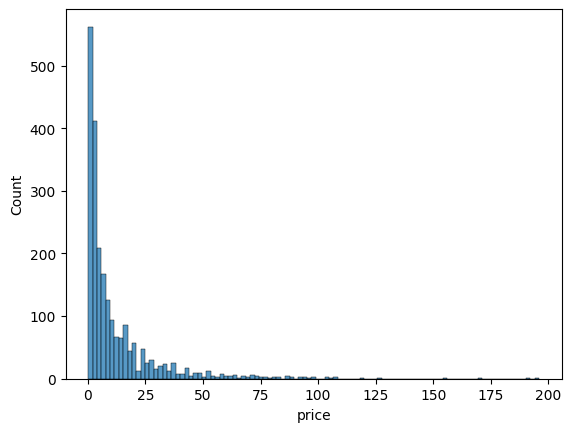

In [ ]:
sns.histplot(x=target)

Notice the hump of midfielders and defenders around 40 million, empirically it'd say that it's due to the difference in evaluation between good defenders and good forwards. In fact these are the majority around 100 million so this means the role has a correlation with the target

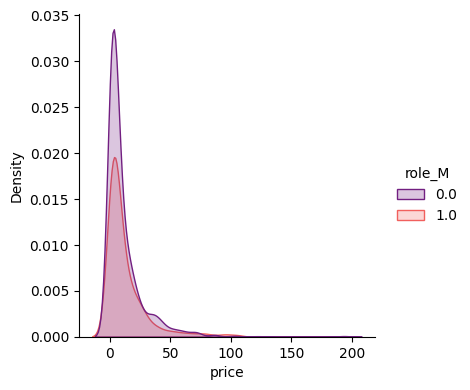

In [ ]:
sns.displot(x=target, height = 4, kind='kde', hue=df['role_M'], fill=True, palette='magma')

Also age influences the price, see as this increases how more difficult it is to find expensive players

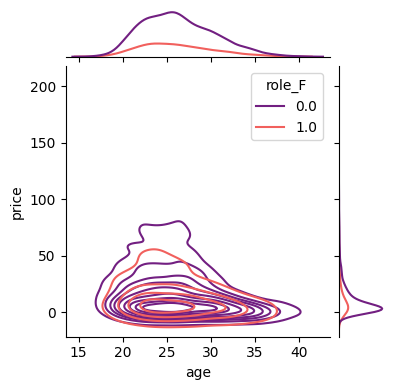

In [ ]:
sns.jointplot(x=df['age'], y=target, kind='kde', hue=df['role_F'], height = 4, palette='magma')

The proportions between forwards among leagues and other positions stay the same, but it's interesting to underline the lack of players in the Portuguese league. This is probably due to Sofascore not having enough data of minor Portuguese teams

<Axes: xlabel='role_F', ylabel='count'>

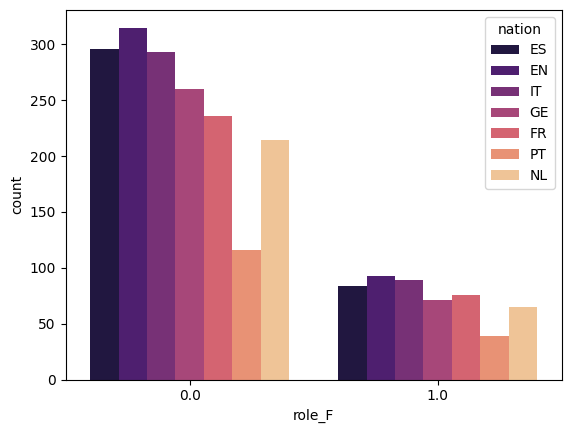

In [ ]:
sns.countplot(data = df, x = 'role_F', hue = 'nation', palette='magma')

Position on the pitch influences goals and also often represents a player's skills: this is how defenders and midfielders have a higher percentage of interventions than attackers, being used to defending

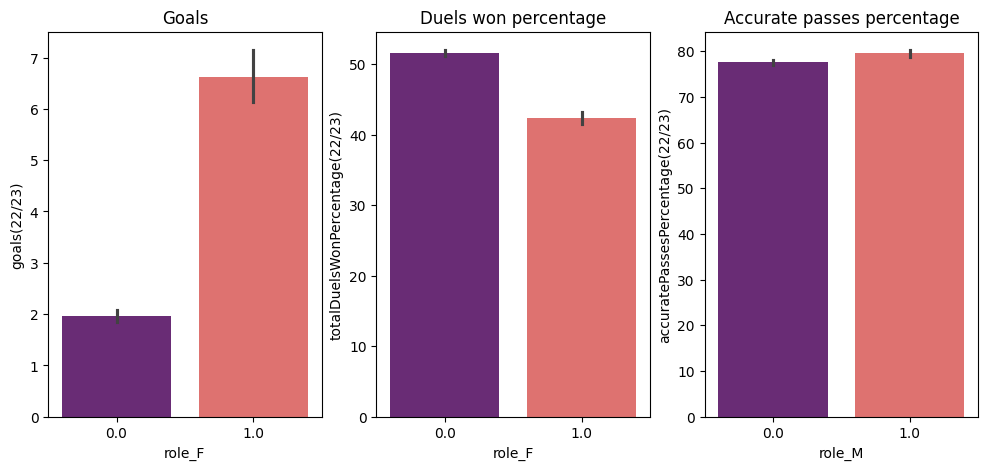

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
axes[0].set_title('Goals')
sns.barplot(x=df['role_F'], y=df['goals(22/23)'], palette='magma', ax=axes[0])
axes[1].set_title('Duels won percentage')
sns.barplot(x=df['role_F'], y=df['totalDuelsWonPercentage(22/23)'], palette='magma', ax=axes[1])
axes[2].set_title('Accurate passes percentage')
sns.barplot(x=df['role_M'], y=df['accuratePassesPercentage(22/23)'], palette='magma', ax=axes[2])
plt.show()

Curious statistic that shows the best ratings go to the attackers while the worst go to the midfielders or defenders. This is probably caused in a bias that sees the goal, which often comes from the attackers, as the most important detachment action in football as opposed to a save before the opponent is about to shoot

<Axes: xlabel='nation', ylabel='rating(22/23)'>

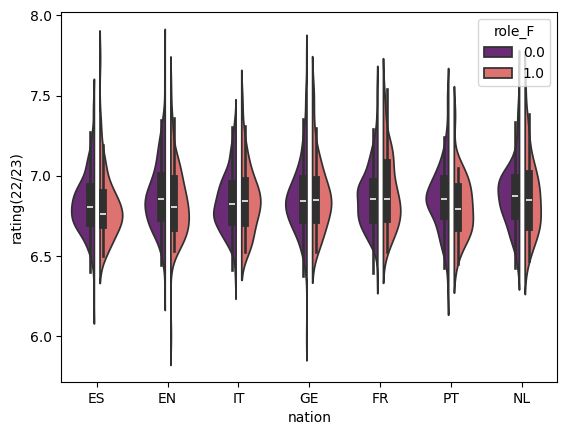

In [ ]:
sns.violinplot(x=df[df['rating(22/23)'] != 0]['nation'], y=df[df['rating(22/23)'] != 0]['rating(22/23)'], palette='magma', hue=df[df['rating(22/23)'] != 0]['role_F'], split=True, gap=.2)

The English market is currently a world apart when it comes to prices: just think that the most expensive purchase last summer in Serie A was Pavard for 30 million while in England Rice was for 116.

<Axes: xlabel='nation', ylabel='price'>

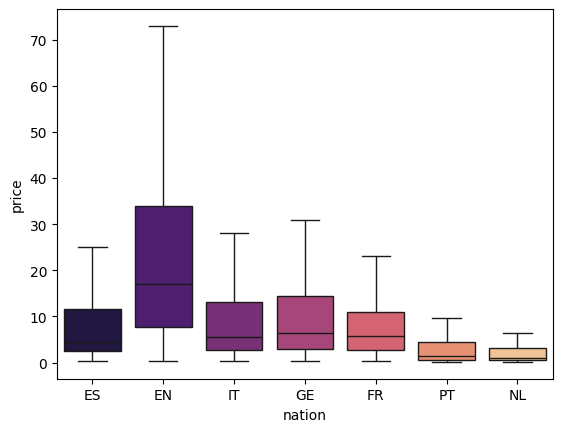

In [ ]:
sns.boxplot(x=df['nation'], y=target, showfliers=False, palette='magma')

We transform the categorical columns using get_dummies since they are nominal. Then we apply a standard scaler on all features except binary ones

In [ ]:
df = pd.get_dummies(df, columns=['nation'], drop_first=False)
features = df.columns
binary_features = ['role_F', 'role_M', 'nation_EN','nation_ES', 'nation_FR', 'nation_GE', 'nation_IT', 'nation_NL','nation_PT']

# Identify numerical features
numerical_features = df.columns.difference(binary_features)

# Define the transformers for each type of feature
transformers = [
    ('numerical', StandardScaler(), numerical_features),
    ('passthrough', 'passthrough', binary_features)  # 'passthrough' means no transformation
]

preprocessor = ColumnTransformer(transformers)

scaler = StandardScaler()
X_train, X_test, y_train, y_test, Names_train, Names_test = train_test_split(df, target, names, test_size=0.2, random_state=101)

X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns=features)
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=features)


X_train = pd.DataFrame(X_train, columns=df.columns)
X_test = pd.DataFrame(X_test, columns = df.columns)

Considering the main statistics from last season, interesting correlations can be seen:
- negative between GroundDuelsWonPercentage and KeyPasses: usually the so-called "midfield director" excels in sending his teammates to the net, while in the defensive phase he is covered by his midfield teammates who are better at stopping the opponents
- the 0.3 difference in correlation from accurateOwnHalfPasses to accurateOppositionHalfPasses with accuratePasses in general: it's easier to do right passes in your own half since the opponents aren't as dense as in their own half
- positive between aerialDuelsWon and goals: just as players are skilled at winning an aerial duel in contention for the ball, so they use the same skills to head it in from a cross


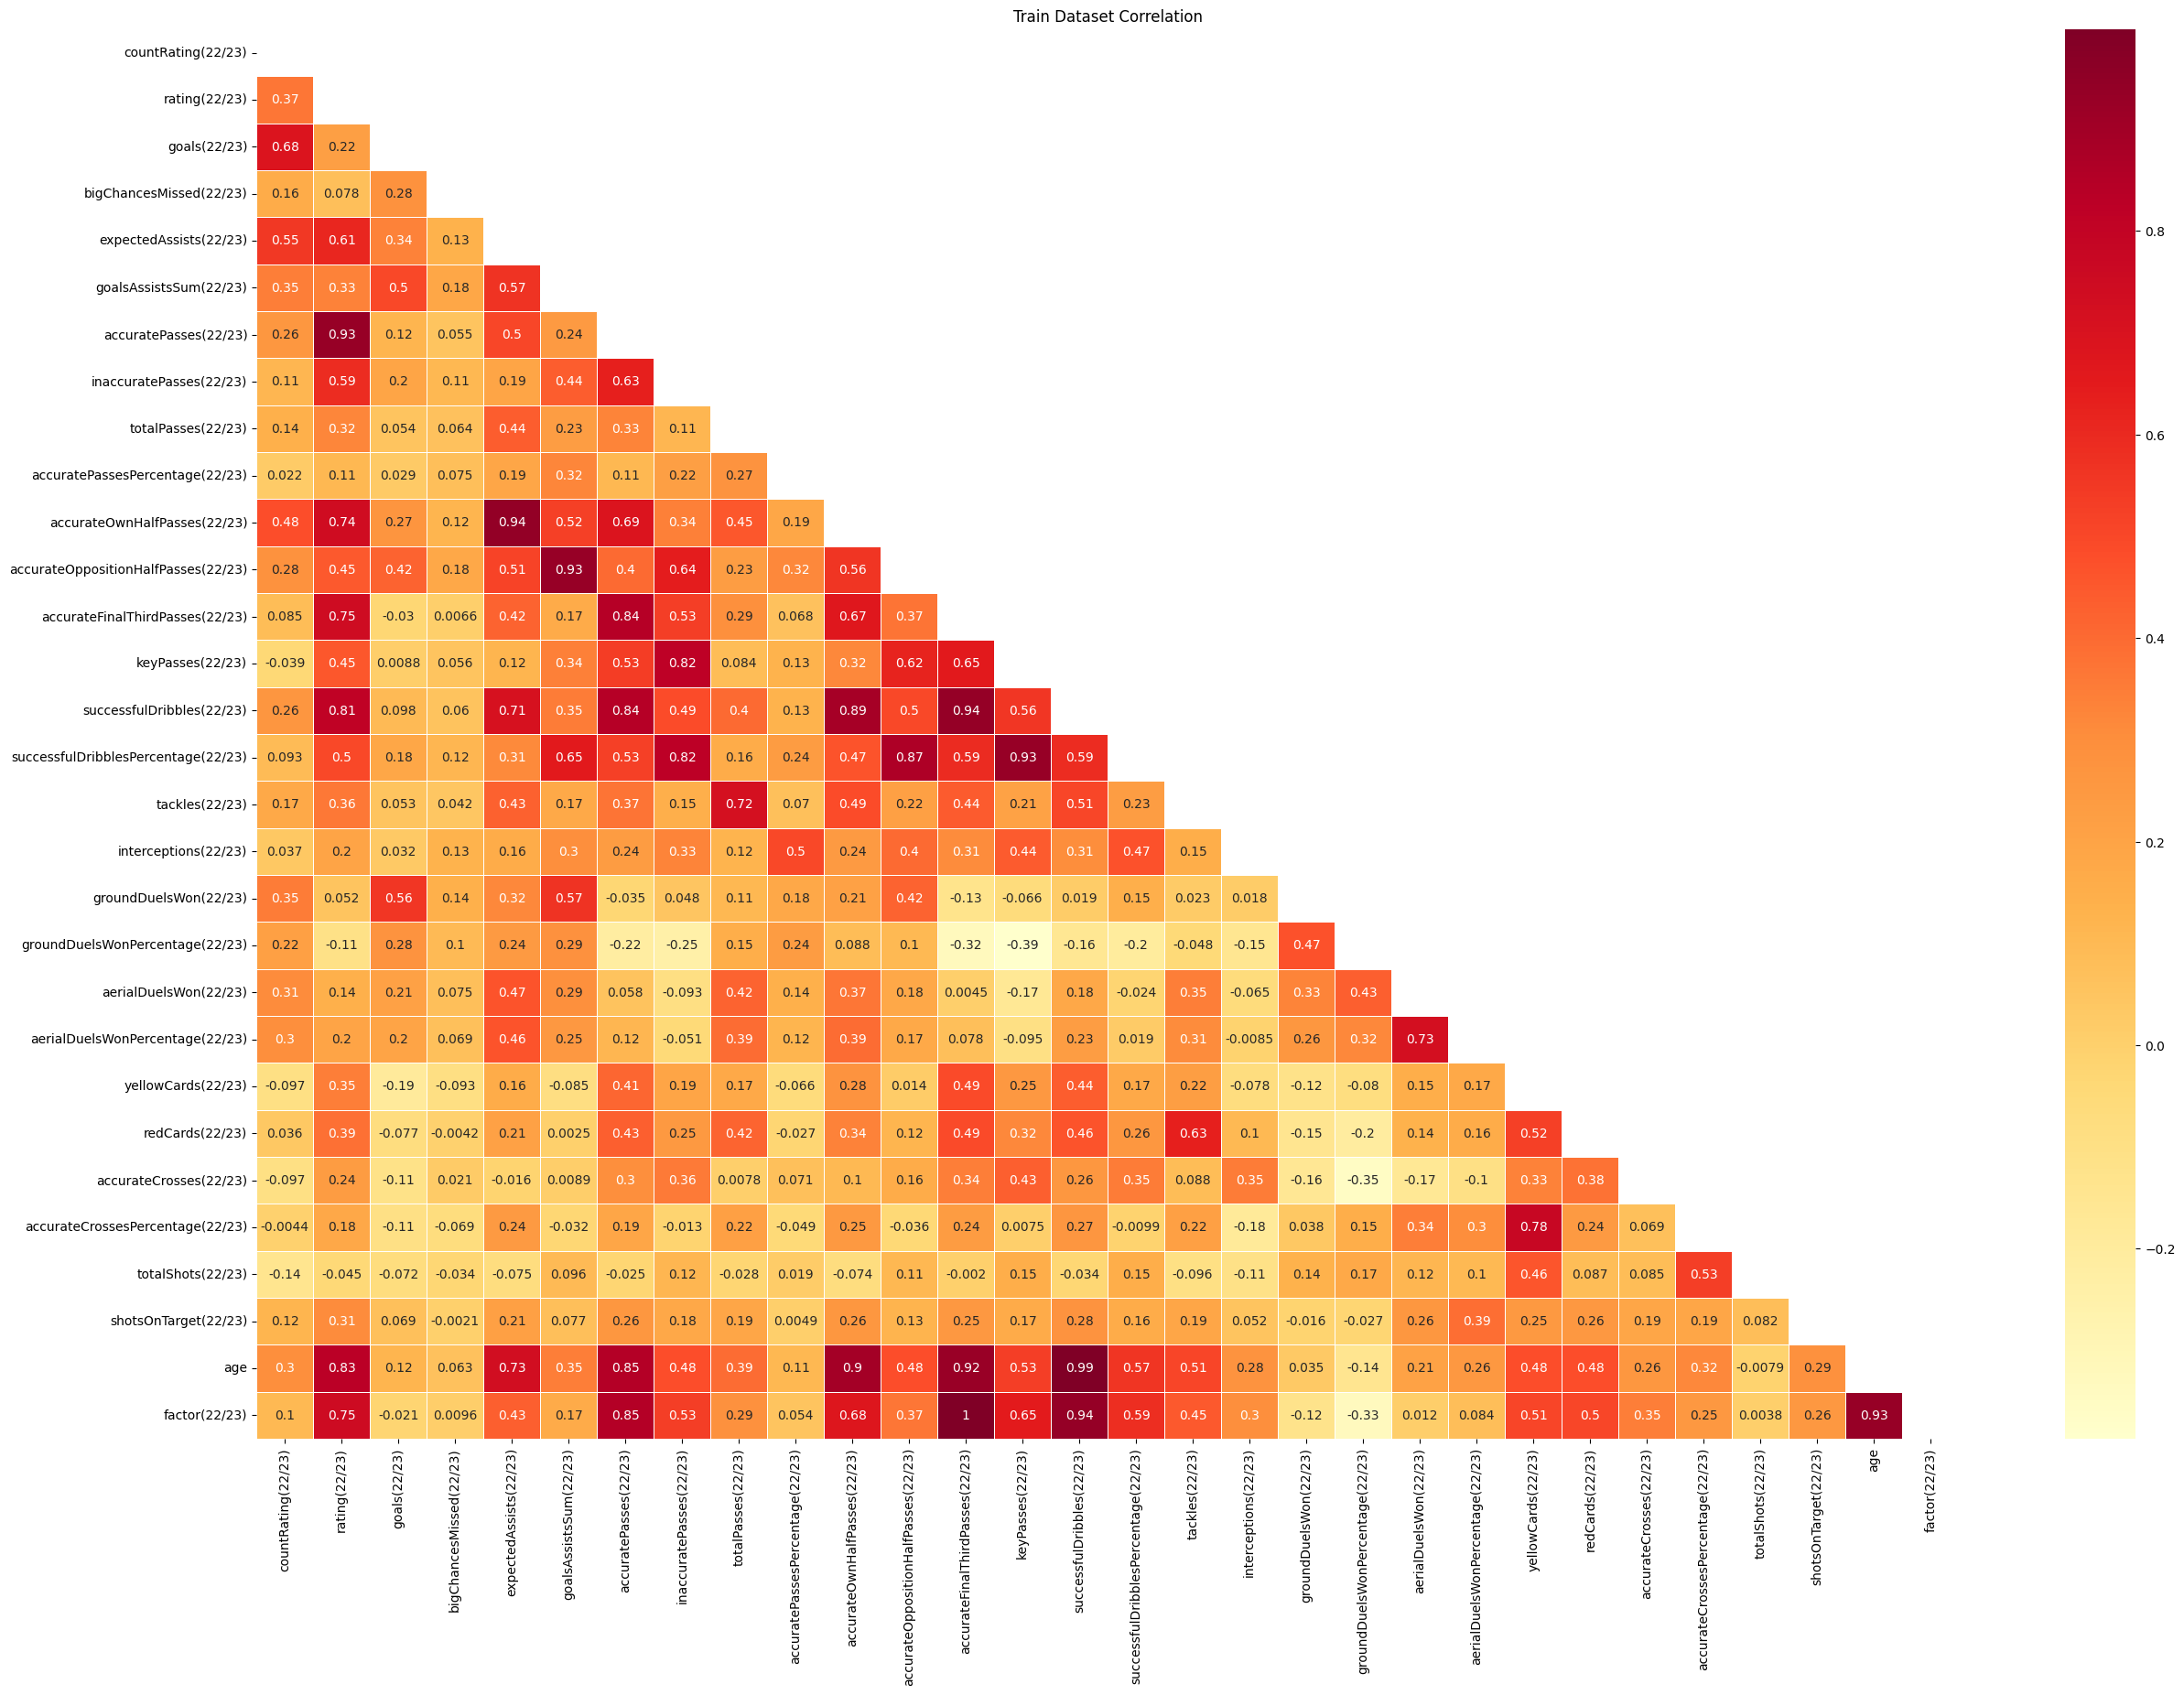

In [ ]:
best_30_features = ['countRating(22/23)','rating(22/23)', 'goals(22/23)', 'bigChancesMissed(22/23)','expectedAssists(22/23)','goalsAssistsSum(22/23)','accuratePasses(22/23)','inaccuratePasses(22/23)','totalPasses(22/23)','accuratePassesPercentage(22/23)','accurateOwnHalfPasses(22/23)','accurateOppositionHalfPasses(22/23)','accurateFinalThirdPasses(22/23)','keyPasses(22/23)','successfulDribbles(22/23)','successfulDribblesPercentage(22/23)','tackles(22/23)','interceptions(22/23)','groundDuelsWon(22/23)','groundDuelsWonPercentage(22/23)','aerialDuelsWon(22/23)','aerialDuelsWonPercentage(22/23)','yellowCards(22/23)','redCards(22/23)','accurateCrosses(22/23)','accurateCrossesPercentage(22/23)','totalShots(22/23)','shotsOnTarget(22/23)','age', 'factor(22/23)']

def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(30, 20))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# plot_correlation_heatmap(original, 'Original Dataset Correlation')
plot_correlation_heatmap(X_train[best_30_features], 'Train Dataset Correlation')

## Feature Selection

We can eliminate features that only add noise and worsen the performance of our models, for example very particular ones (double yellow) or those referring to goalkeepers. However, the result is not intended to be extreme as information is obtained from almost all the data and removing it would damage the prediction capabilities too much

Information gain

In [ ]:
ig = mutual_info_regression(X_train, y_train)

# Create a dictionary of feature importance scores
feature_scores = {}
for i in range(len(df.columns)):
    feature_scores[df.columns[i]] = ig[i]
# Sort the features by importance score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
featuresToDelete = []
for feature, score in sorted_features:
    if score==0.0 and feature!='role_M' and feature!='role_F' and 'nation' not in feature:
      featuresToDelete.append(feature)

print(f'Number of features before:{len(X_train.columns)}')
X_train = X_train.drop(columns=featuresToDelete)
X_test = X_test.drop(columns=featuresToDelete)
#X_val = X_val.drop(columns=featuresToDelete)
print(f'Number of features after:{len(X_train.columns)}')


Number of features before:235
Number of features after:184


Forward Selection

Since performance continues to improve with added features, I prefer to have a dataset composed of numerous columns which makes the EDA more opaque compared to worse performance

Accuracy: -144.8854973860429


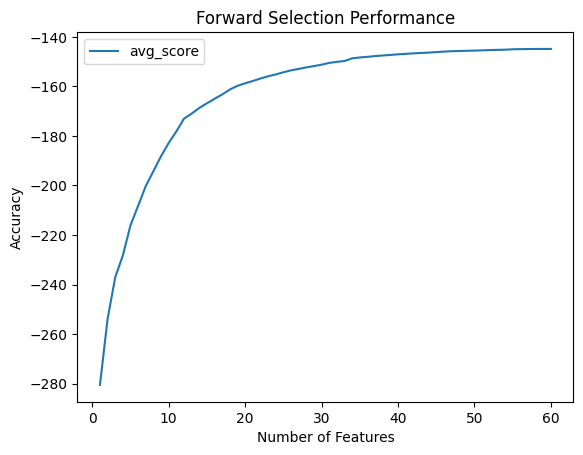

In [ ]:
model = LinearRegression()

# Define the forward selection object
sfs = SFS(model, k_features=60, forward=True, floating=False, scoring="neg_mean_squared_error", cv=2)

# Perform forward selection on the training set
sfs.fit(X_train, y_train)
# Evaluate the performance of the selected features on the testing set
accuracy = sfs.k_score_
print("Accuracy:", accuracy)

# Plot the performance of the model with different feature subsets
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind="line", y="avg_score", ax=ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title("Forward Selection Performance")
plt.show()

In [ ]:
selected_features_mask = list(sfs.k_feature_idx_)
X_train = X_train.iloc[:, selected_features_mask]
X_test = X_test.iloc[:, selected_features_mask]

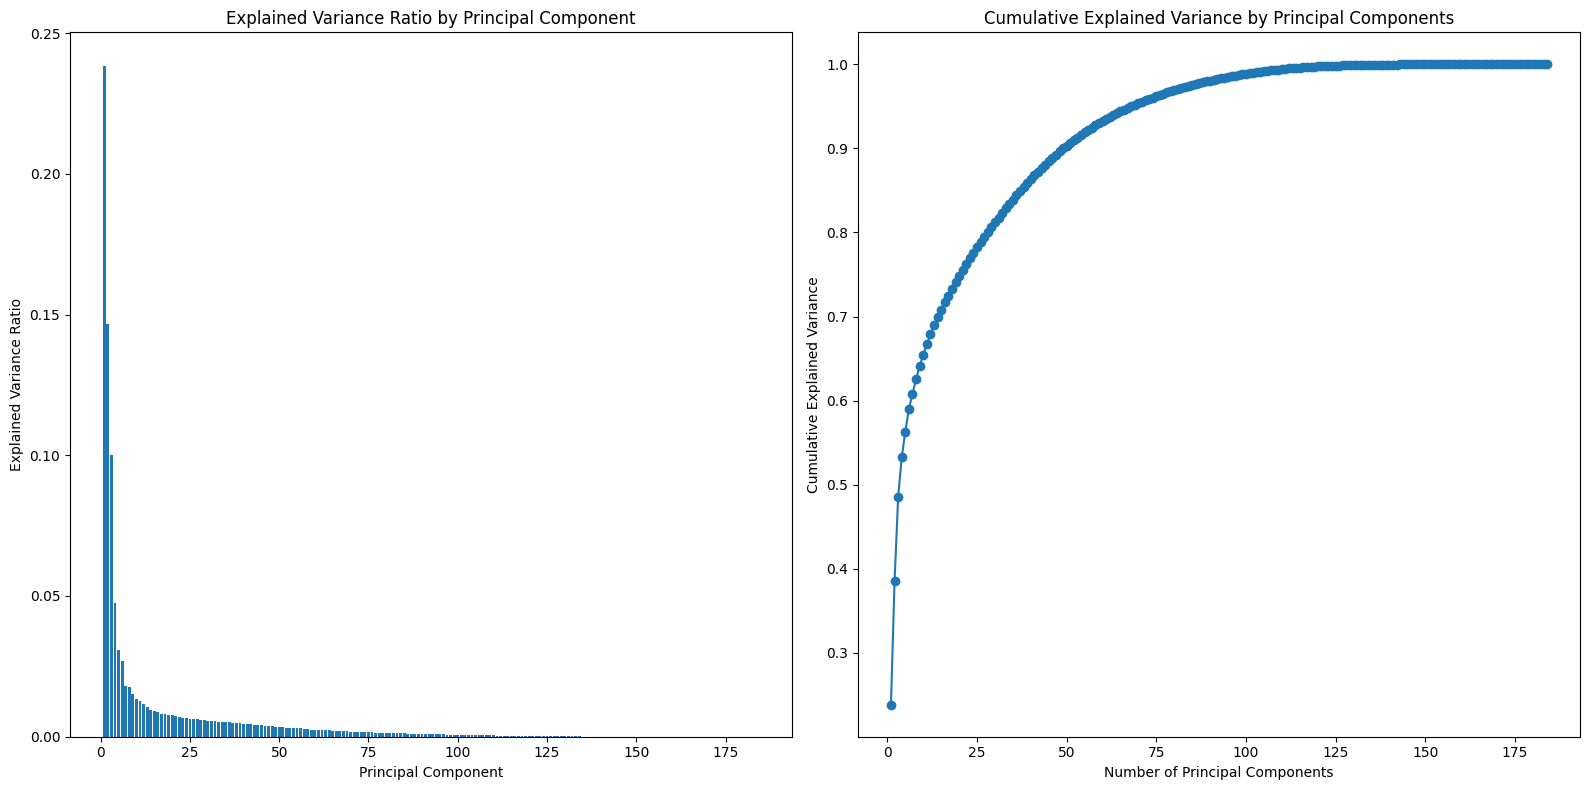

In [ ]:
# @title PCA
pca = PCA()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
features = X_train.columns
X_pca = pca.fit_transform(X_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the explained variance ratio in the first subplot
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance Ratio by Principal Component")

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance in the second subplot
ax2.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
)
ax2.set_xlabel("Number of Principal Components")
ax2.set_ylabel("Cumulative Explained Variance")
ax2.set_title("Cumulative Explained Variance by Principal Components")

# Display the figure
plt.tight_layout()
plt.show()

PCA also confirms that each feature has its own importance and a substantial reduction would not allow for sufficient performance compared to before. It should also be noted that the first 5 principal components group together more than 50% of the information

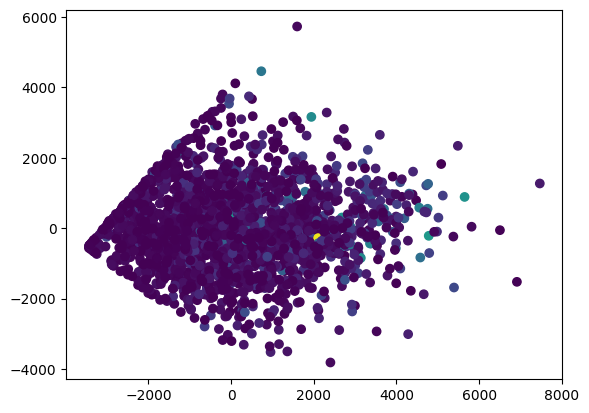

In [ ]:
# @title PCA's structure
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)
x_coords = [point[0] for point in df_pca]
y_coords = [point[1] for point in df_pca]

plt.scatter(x_coords, y_coords, c=target)

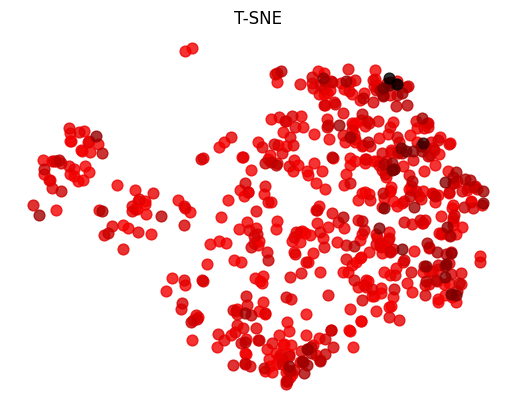

In [ ]:
# @title T-SNE
step_y_train = np.digitize(y_train, [i*10 for i in range(1,20)], right=True)
colors = np.linspace([1, 0, 0], [0, 0, 0], 20)
def plot_embedding(X, title):
    _, ax = plt.subplots()

    for digit in [i for i in range(1,20)]:
        ax.scatter(
            *X[step_y_train == digit].T,
            marker='o',#f"${digit}$"'',
            s=60,
            color=colors[digit],
            alpha=0.8,
            zorder=2,
        )

    ax.set_title(title)
    ax.axis("off")
X = TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ).fit_transform(X_train)
plot_embedding(X,'T-SNE')

The structure obtained from T-SNE is certainly more understandable than that of PCA since the former maintains the local relationships between the samples. In fact, it can be seen that the most valuable players are often close to each other, however clustering would be impossible

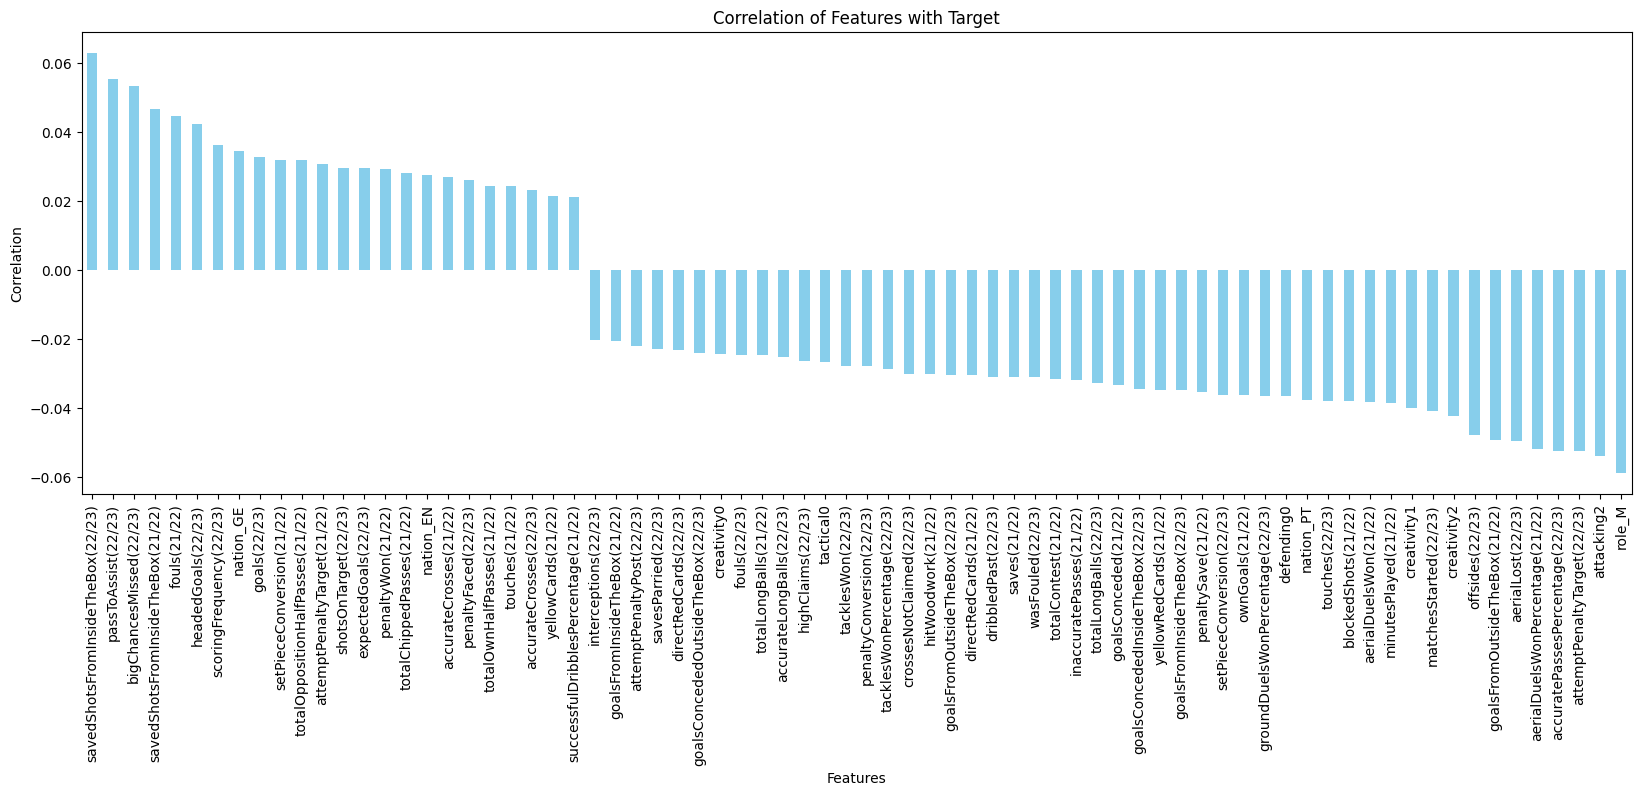

In [ ]:
# @title Correlation with the target
correlations = X_train.apply(lambda x: pd.Series(x).corr(pd.Series(target)))
correlations = correlations[(correlations > 0.02) | (correlations < -0.02)]
# Plot the bar plot
plt.figure(figsize=(20, 6))  # Adjust the width of the figure
ax = correlations.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Target')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

Here we can see the features that have the highest absolute correlation with the target as a high attack two previous seasons is negatively correlated with the market price. This is because it is probably difficult to maintain such a level and consequently it decreases

##General overview of the models

To choose the best performing models we go by exclusion: we eliminate those that are below the minimum bar such as AdaBoostRegressor and Lasso since train all of them would simply require too much time. These models are evaluated using the cross validation with 5 folds and the metrics is the mean squared error thus it's susceptible to outliers

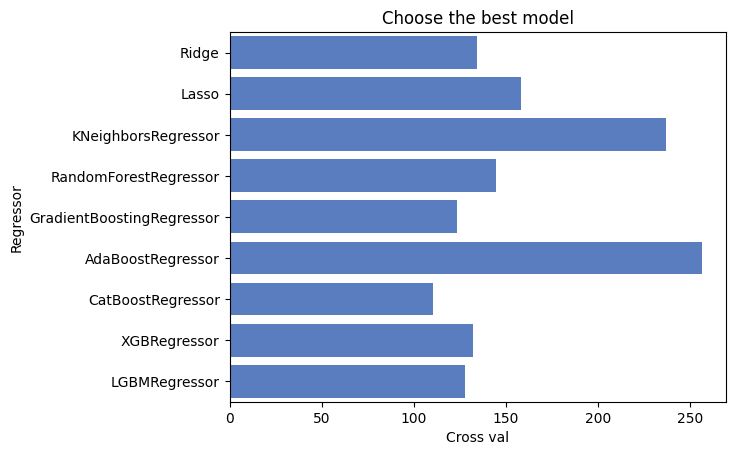

In [ ]:
models = [ Ridge(), Lasso(), KNeighborsRegressor(),RandomForestRegressor(), GradientBoostingRegressor(),AdaBoostRegressor(), CatBoostRegressor(iterations=500, verbose=0), xgb.XGBRegressor(), LGBMRegressor(verbose=-1)]
log_cols=["Regressor", "Cross Val"]
log = pd.DataFrame(columns=log_cols)

for clf in models:
    name = clf.__class__.__name__
    acc = -cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    log_entry = pd.DataFrame([[name, acc]], columns=log_cols)
    log = log.append(log_entry)
sns.set_color_codes("muted")
sns.barplot(x='Cross Val', y='Regressor', data=log, color="b")

plt.xlabel('Cross val')
plt.title('Choose the best model')
plt.show()

##Nested Cross Validation

We have excluded the less performing models, it is now time to take the more performing models and use them for our prediction. To do this, we initially use nested cross validation to understand which range of values for the hyperparameters is acceptable and at the same time which model works better than others.

In [ ]:
model_pipeline = IMBPipeline([
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', LinearRegression())
])

In [ ]:
regressor_configs= [{
    'classifier': [RandomForestRegressor()],
    'classifier__n_estimators' : np.arange(10,500, 10),
    'classifier__min_samples_split': range(2, 10),
    'classifier__max_depth' : range(2, 32)
  },
  {
      'classifier':[xgb.XGBRegressor()],
      'classifier__max_depth': range(3,10),
      'classifier__learning_rate': loguniform(0.01,3)
  },
   {
      'classifier': [GradientBoostingRegressor()],
      'classifier__max_depth':range(5,16,2),
      'classifier__min_samples_split':range(200,1001,200),
      'classifier__min_samples_split':range(1000,2100,200),
      'classifier__min_samples_leaf':range(30,71,10)
  }, {
      'classifier': [CatBoostRegressor(verbose=0)],
      'classifier__iterations':[250],
      "classifier__learning_rate": np.arange(1e-3, 0.1, 0.001),
      "classifier__depth": range(1, 10),
      "classifier__subsample": np.arange(0.05, 1.0, 0.05)
      },
  {
      'classifier': [LGBMRegressor(verbose=-1)],
      'classifier__max_depth': range(5, 10),
      'classifier__min_child_samples': range(1, 20),
      'classifier__learning_rate': np.arange(0.01, 1.0, 0.01),
      'classifier__n_estimators': range(150, 1000)
  }]
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.85, 0.9, 0.95]
    }]

hs_log = RandomizedSearchCV(estimator=model_pipeline,param_distributions=regressor_configs,scoring='neg_mean_squared_error',n_iter=20,cv=5,verbose=1)

scores = cross_validate(hs_log, X_train, y_train,scoring='neg_mean_squared_error', cv=5, verbose=3, return_estimator=True)
#print(f'CV F1-score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...................................., score=-167.551 total time= 2.4min
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...................................., score=-189.728 total time= 3.1min
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...................................., score=-160.606 total time= 4.3min
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...................................., score=-237.491 total time= 4.5min
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...................................., score=-185.483 total time= 3.5min


In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

<catboost.core.CatBoostRegressor object at 0x7951cbb8e860> {'iterations': 250, 'learning_rate': 0.095, 'depth': 4, 'loss_function': 'RMSE', 'verbose': 0, 'subsample': 0.05}
-167.55113044561006
----------
<catboost.core.CatBoostRegressor object at 0x7951db072dd0> {'iterations': 250, 'learning_rate': 0.064, 'depth': 4, 'loss_function': 'RMSE', 'verbose': 0, 'subsample': 0.5}
-189.7284502232699
----------
<catboost.core.CatBoostRegressor object at 0x7951d0baa740> {'iterations': 250, 'learning_rate': 0.095, 'depth': 3, 'loss_function': 'RMSE', 'verbose': 0, 'subsample': 0.8500000000000001}
-160.60625300137593
----------
LGBMRegressor(learning_rate=0.26, max_depth=6, min_child_samples=11,
              n_estimators=694, verbose=-1) {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.26, 'max_depth': 6, 'min_child_samples': 11, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 694, 'n_jobs': None, 'num_leaves

In [ ]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    mae_train = mean_squared_error(y_train, pred_train)
    mae_test = mean_squared_error(y_test, pred_test)
    print(f'MSE on training set:{mae_train}, MSE on test set:{mae_test}')

MSE on training set:99.78140760829908, MSE on test set:174.51027293984924
MSE on training set:76.87963223507447, MSE on test set:167.81617731275063
MSE on training set:75.74918948288, MSE on test set:172.79260131279673
MSE on training set:3.713596709435858e-09, MSE on test set:192.31764125393707
MSE on training set:45.182475653121664, MSE on test set:163.78730802543527


Putting together the results of the nested-cross-validation, the previous general overview and my experience I decided to keep CatBoost, XGBoost and LightBoost. Therefore now through Optuna we will find the perfect hyperparameters in order to balance performance and not high overfitting, through a cross validation with 5 folds that allow us to have a realistic vision of our models

##Optuna Catboost

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
def objective(trial):
    param_distributions = {        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 3, 8),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        }
    mae=[]
    model = CatBoostRegressor(**param_distributions, random_state=42, verbose=0)
    for train_index, val_index in cv.split(X_train, y_train):
        X_train2, X_test2 = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train2, y_test2 = y_train.iloc[train_index], y_train.iloc[val_index]
        X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42)
        model.fit(X_train2, y_train2, eval_set=[(X_val2, y_val2)], early_stopping_rounds=50)
        y_pred = model.predict(X_test2)
        mae.append(mean_squared_error(y_test2, y_pred))
    mae = sum(mae) / len(mae)
    return mae
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective, n_trials=100)

[I 2024-01-29 12:57:12,235] A new study created in memory with name: no-name-213cb2a6-c07d-4514-9bd6-69c6765804e5
[I 2024-01-29 12:57:29,488] Trial 0 finished with value: 120.26762986385422 and parameters: {'learning_rate': 0.0925706790699069, 'depth': 5, 'subsample': 0.8543388478032284, 'colsample_bylevel': 0.921102412785244, 'min_data_in_leaf': 35}. Best is trial 0 with value: 120.26762986385422.
[I 2024-01-29 12:59:04,041] Trial 1 finished with value: 210.8888379576675 and parameters: {'learning_rate': 0.004173714072387757, 'depth': 8, 'subsample': 0.598235472415965, 'colsample_bylevel': 0.5289308544182467, 'min_data_in_leaf': 47}. Best is trial 0 with value: 120.26762986385422.
[I 2024-01-29 13:00:13,899] Trial 2 finished with value: 130.90104634654776 and parameters: {'learning_rate': 0.06130335341458009, 'depth': 7, 'subsample': 0.14617993724939166, 'colsample_bylevel': 0.9269865589552052, 'min_data_in_leaf': 23}. Best is trial 0 with value: 120.26762986385422.
[I 2024-01-29 13:0

In [ ]:
model = CatBoostRegressor(**study_cat.best_trial.params, iterations=500, verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
#84
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Mean Absolute Error on Test Set: {mae}')

Mean Squared Error on Test Set: 84.636147307756
Mean Absolute Error on Test Set: 5.589790937545433


In [ ]:
def plot_learning(title, range, train_scores, test_scores):
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  fig=plt.figure(figsize=(12,7))
  ax = fig.add_subplot()
  ax.plot(range, train_mean,
          color='blue', marker='o',
          markersize=5, label='Training accuracy')

  ax.fill_between(range,
                  train_mean + train_std,
                  train_mean - train_std,
                  alpha=0.15, color='blue')

  ax.plot(range, test_mean,
          color='green', linestyle='--',
          marker='s', markersize=5,
          label='Validation accuracy')

  ax.fill_between(range,
                  test_mean + test_std,
                  test_mean - test_std,
                  alpha=0.15, color='green')

  ax.grid()
  ax.set_xlabel(title)
  ax.set_ylabel('MSE')
  ax.legend(loc='lower right')
  #ax.set_xscale('log')

def parameter_learning_curve(model):
  train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                        cv = 5,
                                                        n_jobs = -1,
                                                        scoring = 'neg_mean_squared_error',
                                                        shuffle = False)
  plot_learning('train size', train_sizes, train_scores, test_scores)


##Optuna XGBoost

In [ ]:
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'alpha': trial.suggest_float('alpha', 0, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000, step = 50),
        'n_jobs': -1  # Use all available processors
    }

    # Add a callback for pruning.
    model = xgb.XGBRegressor(**param)
    #model.fit(X_train, y_train)
    mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    mse = mse_scores.mean()

    return mse
study = optuna.create_study(direction='minimize')  # or 'maximize' if optimizing a metric like accuracy
study.optimize(objective, n_trials=100)

[I 2024-01-29 13:35:57,211] A new study created in memory with name: no-name-5efc2ae0-5149-4e6c-b8e4-9075934e8472
[I 2024-01-29 13:36:51,909] Trial 0 finished with value: 113.65315840521734 and parameters: {'colsample_bytree': 0.9610975623172516, 'learning_rate': 0.24687649945284193, 'max_depth': 5, 'alpha': 7.199246330222873, 'n_estimators': 4800}. Best is trial 0 with value: 113.65315840521734.
[I 2024-01-29 13:38:42,006] Trial 1 finished with value: 120.76835382847563 and parameters: {'colsample_bytree': 0.8736511341828826, 'learning_rate': 0.09610166266239265, 'max_depth': 7, 'alpha': 9.280370087177065, 'n_estimators': 9450}. Best is trial 0 with value: 113.65315840521734.
[I 2024-01-29 13:39:10,301] Trial 2 finished with value: 120.98845055642369 and parameters: {'colsample_bytree': 0.41277027254551846, 'learning_rate': 0.2593424881057577, 'max_depth': 3, 'alpha': 0.8287751490521433, 'n_estimators': 2350}. Best is trial 0 with value: 113.65315840521734.
[I 2024-01-29 13:40:19,676]

KeyboardInterrupt: 

In [ ]:
model = xgb.XGBRegressor(**{'colsample_bytree': 0.4751412682361793, 'learning_rate': 0.02271952649809095, 'max_depth': 3, 'alpha': 5.9528394858303155, 'n_estimators': 4400})
model.fit(X_train, y_train)
y_pred2 = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred2)
mae = mean_absolute_error(y_test, y_pred2)
#83
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Mean Absolute Error on Test Set: {mae}')

Mean Squared Error on Test Set: 84.17088012790705
Mean Absolute Error on Test Set: 5.743658156415821


In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

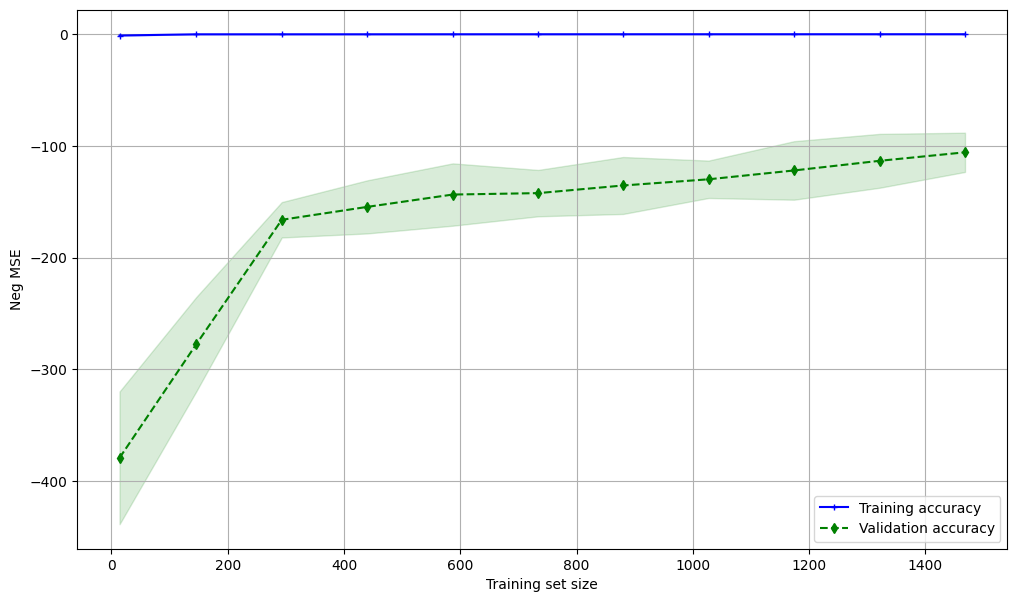

In [ ]:
parameter_learning_curve(model)

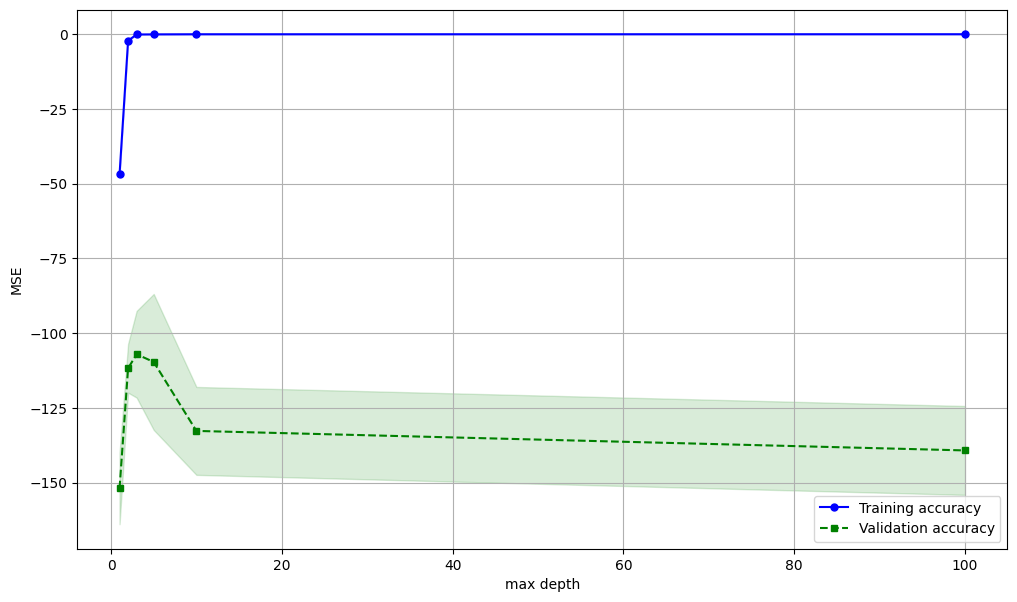

In [ ]:
range_max_depth = [1,2,3, 5, 10, 100]
train_scores, test_scores = validation_curve(model,
        X=X_train,
        y=y_train,
        param_range=range_max_depth,
        param_name='max_depth',
        cv=5,
        n_jobs=-1,
        scoring='neg_mean_squared_error'
)
plot_learning('max depth', range_max_depth, train_scores, test_scores)

##Optuna LightBoost

In [ ]:
from optuna.integration import LightGBMPruningCallback
cv = KFold(n_splits=5, shuffle=True, random_state=42)
def objective(trial):
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 10000, step=1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 100, step=10),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    #mse_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    #mse = mse_scores.mean()
    mse=[]
    for train_index, val_index in cv.split(X_train, y_train):
        model = LGBMRegressor(**param_grid, verbose =-1)
        X_train2, X_test2 = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train2, y_test2 = y_train.iloc[train_index], y_train.iloc[val_index]
        X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42)
        model.fit(X_train2, y_train2, eval_set=[(X_val2, y_val2)], eval_metric="l2",callbacks=[LightGBMPruningCallback(trial, "l2")])
        y_pred = model.predict(X_test2)
        mse.append(mean_squared_error(y_test2, y_pred))
    return sum(mse)/len(mse)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-01-28 17:38:47,313] A new study created in memory with name: no-name-2305b4b9-a856-4190-b247-0a2bcb107310
[I 2024-01-28 17:38:59,266] Trial 0 finished with value: 206.21066300843222 and parameters: {'n_estimators': 3000, 'learning_rate': 0.2521081469996034, 'num_leaves': 1020, 'max_depth': 8, 'min_data_in_leaf': 30, 'lambda_l1': 50, 'lambda_l2': 100, 'min_gain_to_split': 9.52995653006884, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: 206.21066300843222.
[I 2024-01-28 17:39:11,143] Trial 1 finished with value: 153.1969819952954 and parameters: {'n_estimators': 3000, 'learning_rate': 0.0319964446509168, 'num_leaves': 300, 'max_depth': 3, 'min_data_in_leaf': 0, 'lambda_l1': 10, 'lambda_l2': 70, 'min_gain_to_split': 9.055555198165477, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 1 with value: 153.1969819952954.
[I 2024-01-28 17:39:20,752] Trial 2 finished with value: 171.90118

In [ ]:
model = LGBMRegressor(**study.best_trial.params, verbose=-1)
model.fit(X_train, y_train)
y_pred2 = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred2)
mae = mean_absolute_error(y_test, y_pred2)

print(f'Mean Squared Error on Test Set: {mse}')
print(f'Mean Absolute Error on Test Set: {mae}')

Mean Squared Error on Test Set: 127.1553598675424
Mean Absolute Error on Test Set: 7.502894616071248


##Optuna GradientBoosting

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }
    model = GradientBoostingRegressor(**params, random_state=42)
    mse_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    mse = mse_scores.mean()
    return mse
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-01-27 14:39:50,441] A new study created in memory with name: no-name-3a0f1585-9326-472f-a33f-04aca942f2fc
[I 2024-01-27 14:39:53,916] Trial 0 finished with value: 185.99802874786803 and parameters: {'n_estimators': 83, 'learning_rate': 0.16712372643884355, 'max_depth': 6, 'min_samples_split': 41, 'min_samples_leaf': 81, 'subsample': 0.5705756791826102}. Best is trial 0 with value: 185.99802874786803.
[I 2024-01-27 14:39:58,006] Trial 1 finished with value: 184.03475453518385 and parameters: {'n_estimators': 111, 'learning_rate': 0.175631091646558, 'max_depth': 2, 'min_samples_split': 91, 'min_samples_leaf': 4, 'subsample': 0.6337424012363346}. Best is trial 1 with value: 184.03475453518385.
[I 2024-01-27 14:40:03,937] Trial 2 finished with value: 186.732166680964 and parameters: {'n_estimators': 87, 'learning_rate': 0.06309704176821149, 'max_depth': 4, 'min_samples_split': 36, 'min_samples_leaf': 70, 'subsample': 0.8700148895426766}. Best is trial 1 with value: 184.034754535183

KeyboardInterrupt: 

In [ ]:
model = GradientBoostingRegressor(**{'n_estimators': 183, 'learning_rate': 0.09505162610816119, 'max_depth': 5, 'min_samples_split': 66, 'min_samples_leaf': 18, 'subsample': 0.9180501715462202})
model.fit(X_train, y_train)
y_pred2 = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred2)
mae = mean_absolute_error(y_test, y_pred2)
#102
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Mean Absolute Error on Test Set: {mae}')

Mean Squared Error on Test Set: 98.80139721252021
Mean Absolute Error on Test Set: 5.921533471512636


#Ensemble

To improve the results, given that we have found not just one but several well-performing models, we can use the concept of ensemble learning, and try it in its various forms. These are the 7 models at the base level (0) with the best results on the training set so we will focus on choosing the level-1 model that takes in input their predictions

In [ ]:
# @title Average
Cat_model = CatBoostRegressor(**{'learning_rate': 0.07217412251185185, 'depth': 4, 'subsample': 0.5667516634306501, 'colsample_bylevel': 0.4490422697676689, 'min_data_in_leaf': 89}, iterations=500, verbose=0)
Cat_model2 = CatBoostRegressor(**{'learning_rate': 0.08802791238828561, 'depth': 4, 'subsample': 0.7433593393002921, 'colsample_bylevel': 0.6027746631533515, 'min_data_in_leaf': 100},iterations=500, verbose = 0)
Gradient_model = GradientBoostingRegressor(**{'n_estimators': 217, 'learning_rate': 0.06530868858026256, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 16, 'subsample': 0.646410720353181})
Light_model = LGBMRegressor(**{'n_estimators': 217, 'learning_rate': 0.06530868858026256, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 16, 'subsample': 0.646410720353181},verbose=-1)
XGB_model = xgb.XGBRegressor(**{'colsample_bytree': 0.7052209711702113, 'learning_rate': 0.03467321207394598, 'max_depth': 4, 'alpha': 3.8480026296088337, 'n_estimators': 5850})
XGB_model2 = xgb.XGBRegressor(**{'colsample_bytree': 0.5054705595296819, 'learning_rate': 0.05304399773003024, 'max_depth': 4, 'alpha': 1.4536968112631268, 'n_estimators': 9250})
Gradient_model2 = GradientBoostingRegressor(**{'n_estimators': 192, 'learning_rate': 0.08228963518710648, 'max_depth': 5, 'min_samples_split': 61, 'min_samples_leaf': 19, 'subsample': 0.9385717124259155})
Cat_model.fit(X_train, y_train)
Cat_model2.fit(X_train, y_train)
Gradient_model.fit(X_train, y_train)
Gradient_model2.fit(X_train, y_train)
Light_model.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)
XGB_model2.fit(X_train, y_train)
XGB_pred = pd.Series(XGB_model.predict(X_test))
XGB_pred2 = pd.Series(XGB_model2.predict(X_test))

Cat_pred = pd.Series(Cat_model.predict(X_test))
Cat_pred2 = pd.Series(Cat_model2.predict(X_test))

Gradient_pred = pd.Series(Gradient_model.predict(X_test))
Gradient_pred2 = pd.Series(Gradient_model2.predict(X_test))

Light_pred = pd.Series(Light_model.predict(X_test))

X_Stest = pd.DataFrame({'XGB':XGB_pred,'Cat':Cat_pred,'Gradient': Gradient_pred, 'Cat2':Cat_pred2, 'XGB2':XGB_pred2, 'Gradient2':Gradient_pred2, 'Light':Light_pred})
row_average = X_Stest.mean(axis=1)
average_series = pd.Series(row_average, name='RowAverage')
mse = mean_squared_error(y_test, average_series)
mae = mean_absolute_error(y_test, average_series)

print(f'Mean Squared Error on Test Set: {mse}')
print(f'Mean Absolute Error on Test Set: {mae}')

Mean Squared Error on Test Set: 84.72138982971296
Mean Absolute Error on Test Set: 5.486412354932951


In [ ]:
# @title Stacking
def get_stacking():
 level0 = list()
 level0.append(('Cat', CatBoostRegressor(**{'learning_rate': 0.07217412251185185, 'depth': 4, 'subsample': 0.5667516634306501, 'colsample_bylevel': 0.4490422697676689, 'min_data_in_leaf': 89}, iterations=500, verbose=0)))
 level0.append(('Cat2', CatBoostRegressor(**{'learning_rate': 0.08802791238828561, 'depth': 4, 'subsample': 0.7433593393002921, 'colsample_bylevel': 0.6027746631533515, 'min_data_in_leaf': 100},iterations=500, verbose = 0)))
 level0.append(('XGB', xgb.XGBRegressor(**{'colsample_bytree': 0.7052209711702113, 'learning_rate': 0.03467321207394598, 'max_depth': 4, 'alpha': 3.8480026296088337, 'n_estimators': 5850})))
 level0.append(('XGB2', xgb.XGBRegressor(**{'colsample_bytree': 0.5054705595296819, 'learning_rate': 0.05304399773003024, 'max_depth': 4, 'alpha': 1.4536968112631268, 'n_estimators': 9250})))
 level0.append(('Light', LGBMRegressor(**{'n_estimators': 217, 'learning_rate': 0.06530868858026256, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 16, 'subsample': 0.646410720353181},verbose=-1)))
 level0.append(('Gradient', GradientBoostingRegressor(**{'n_estimators': 183, 'learning_rate': 0.09505162610816119, 'max_depth': 5, 'min_samples_split': 66, 'min_samples_leaf': 18, 'subsample': 0.9180501715462202})))
 level0.append(('Gradient2', GradientBoostingRegressor(**{'n_estimators': 192, 'learning_rate': 0.08228963518710648, 'max_depth': 5, 'min_samples_split': 61, 'min_samples_leaf': 19, 'subsample': 0.9385717124259155})))
 level1 = Ridge()
 model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)
 return model
stacking = get_stacking()
stacking.fit(X_train, y_train)
stacking_y_pred = stacking.predict(X_test)
stacking_y_pred[stacking_y_pred<0]=0
mse = mean_squared_error(y_test, stacking_y_pred)
mae = mean_absolute_error(y_test, stacking_y_pred)

print(f'Mean Squared Error on Test Set: {mse}')
print(f'Mean Absolute Error on Test Set: {mae}')

Mean Squared Error on Test Set: 88.32778404782724
Mean Absolute Error on Test Set: 5.62811872200236


##Choosing the meta-model

Up to now we have tried two different ensemble learning techniques, however it is possible to improve the stacking performance by choosing the most suitable model and its hyperparameters. The process from above is similar to the one done previously, but we now save the predictions of the level 0 models in a dataframe so we can do a cross validation and choose the best level 1 model without the risk of overfitting

In [ ]:
# @title Predictions on the train set
cv = KFold(n_splits=10, shuffle=True, random_state=42)

def objective():
    predictions=[]

    for train_index, val_index in cv.split(X_train, y_train):
        X_train2, X_test2 = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train2, y_test2 = y_train.iloc[train_index], y_train.iloc[val_index]
        models = []
        models.append(CatBoostRegressor(**{'learning_rate': 0.07217412251185185, 'depth': 4, 'subsample': 0.5667516634306501, 'colsample_bylevel': 0.4490422697676689, 'min_data_in_leaf': 89}, iterations=500, verbose=0))
        models.append(CatBoostRegressor(**{'learning_rate': 0.08802791238828561, 'depth': 4, 'subsample': 0.7433593393002921, 'colsample_bylevel': 0.6027746631533515, 'min_data_in_leaf': 100},iterations=500, verbose = 0))
        models.append(xgb.XGBRegressor(**{'colsample_bytree': 0.7052209711702113, 'learning_rate': 0.03467321207394598, 'max_depth': 4, 'alpha': 3.8480026296088337, 'n_estimators': 5850}))
        models.append(xgb.XGBRegressor(**{'colsample_bytree': 0.5054705595296819, 'learning_rate': 0.05304399773003024, 'max_depth': 4, 'alpha': 1.4536968112631268, 'n_estimators': 9250}))
        models.append(LGBMRegressor(**{'n_estimators': 217, 'learning_rate': 0.06530868858026256, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 16, 'subsample': 0.646410720353181},verbose=-1))
        models.append(GradientBoostingRegressor(**{'n_estimators': 183, 'learning_rate': 0.09505162610816119, 'max_depth': 5, 'min_samples_split': 66, 'min_samples_leaf': 18, 'subsample': 0.9180501715462202}))
        models.append(GradientBoostingRegressor(**{'n_estimators': 192, 'learning_rate': 0.08228963518710648, 'max_depth': 5, 'min_samples_split': 61, 'min_samples_leaf': 19, 'subsample': 0.9385717124259155}))
        for i in range(len(models)):
          models[i].fit(X_train2, y_train2)
          y_pred = models[i].predict(X_test2)
          if len(predictions)<len(models):
            predictions.append(pd.Series(y_pred))
          else:
            predictions[i]=pd.concat([predictions[i], pd.Series(y_pred)], axis=0)
        if len(predictions)==len(models):
          predictions.append(pd.Series(y_test2))
        else:
          predictions[-1]=pd.concat([predictions[-1], pd.Series(y_test2)], axis=0)
    return predictions
res = objective()
for _ in res:
  _.reset_index(drop=True, inplace=True)
predictions_train_stacking= pd.concat(res, axis=1)
predictions_train_stacking.to_csv('predictions_train_stacking.csv', index=False)

In [ ]:
# @title Predictions on the test set
models = []
predictions=[]
models.append(CatBoostRegressor(**{'learning_rate': 0.07217412251185185, 'depth': 4, 'subsample': 0.5667516634306501, 'colsample_bylevel': 0.4490422697676689, 'min_data_in_leaf': 89}, iterations=500, verbose=0))
models.append(CatBoostRegressor(**{'learning_rate': 0.08802791238828561, 'depth': 4, 'subsample': 0.7433593393002921, 'colsample_bylevel': 0.6027746631533515, 'min_data_in_leaf': 100},iterations=500, verbose = 0))
models.append(xgb.XGBRegressor(**{'colsample_bytree': 0.7052209711702113, 'learning_rate': 0.03467321207394598, 'max_depth': 4, 'alpha': 3.8480026296088337, 'n_estimators': 5850}))
models.append(xgb.XGBRegressor(**{'colsample_bytree': 0.5054705595296819, 'learning_rate': 0.05304399773003024, 'max_depth': 4, 'alpha': 1.4536968112631268, 'n_estimators': 9250}))
models.append(LGBMRegressor(**{'n_estimators': 217, 'learning_rate': 0.06530868858026256, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 16, 'subsample': 0.646410720353181},verbose=-1))
models.append(GradientBoostingRegressor(**{'n_estimators': 183, 'learning_rate': 0.09505162610816119, 'max_depth': 5, 'min_samples_split': 66, 'min_samples_leaf': 18, 'subsample': 0.9180501715462202}))
models.append(GradientBoostingRegressor(**{'n_estimators': 192, 'learning_rate': 0.08228963518710648, 'max_depth': 5, 'min_samples_split': 61, 'min_samples_leaf': 19, 'subsample': 0.9385717124259155}))
for model in models:
  model.fit(X_train, y_train)
  predictions.append(pd.Series(model.predict(X_test)))
predictions = pd.concat(predictions, axis=1)
predictions.to_csv('predictions_test_stacking.csv', index=False)

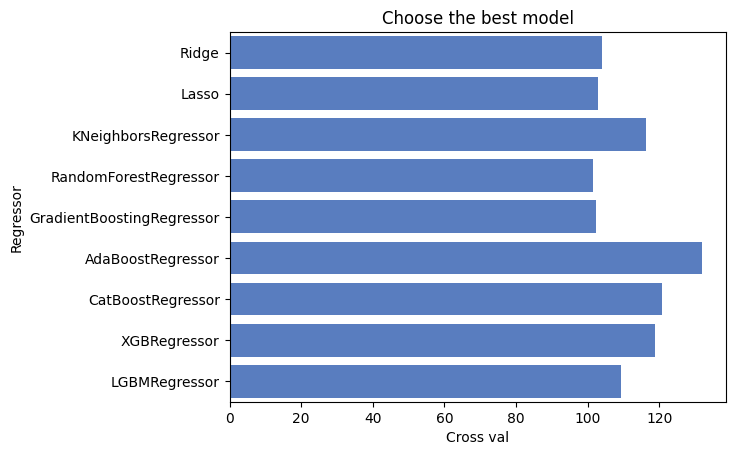

In [ ]:
# @title Performances of different meta-models
models = [ Ridge(), Lasso(), KNeighborsRegressor(),RandomForestRegressor(), GradientBoostingRegressor(),AdaBoostRegressor(), CatBoostRegressor(iterations=100, verbose=0), xgb.XGBRegressor(), LGBMRegressor(verbose=-1)]
log_cols=["Regressor", "Cross Val"]
log = pd.DataFrame(columns=log_cols)
predictions_train_stacking = pd.read_csv('predictions_train_stacking.csv')

for clf in models:
    name = clf.__class__.__name__
    acc = -cross_val_score(clf, predictions_train_stacking.iloc[:, :7], predictions_train_stacking.iloc[:, 7], cv=5, scoring='neg_mean_squared_error').mean()
    log_entry = pd.DataFrame([[name, acc]], columns=log_cols)
    log = log.append(log_entry)
sns.set_color_codes("muted")
sns.barplot(x='Cross Val', y='Regressor', data=log, color="b")

plt.xlabel('Cross val')
plt.title('Choose the best model')
plt.show()

Although Random Forest has excellent performance, I prefer to choose XGBoost because in my opinion it has the most effective hyperparameter tuning

In [ ]:
# @title XGBoost - Optuna on the train set
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'alpha': trial.suggest_float('alpha', 0, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000, step = 50),
        'n_jobs': -1  # Use all available processors
    }

    # Add a callback for pruning.
    model = xgb.XGBRegressor(**param)
    #model.fit(X_train, y_train)
    mse_scores = -cross_val_score(model, predictions_train_stacking.iloc[:, :7], predictions_train_stacking.iloc[:, 7], cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    mse = mse_scores.mean()

    return mse
study = optuna.create_study(direction='minimize')  # or 'maximize' if optimizing a metric like accuracy
study.optimize(objective, n_trials=100)

[I 2024-01-29 20:28:32,983] Trial 100 finished with value: 113.91624794324407 and parameters: {'colsample_bytree': 0.39508215391625373, 'learning_rate': 0.03424117729270548, 'max_depth': 3, 'alpha': 4.306831024630681, 'n_estimators': 1700}. Best is trial 61 with value: 102.17704896719019.
[I 2024-01-29 20:28:33,730] Trial 101 finished with value: 106.24699619887335 and parameters: {'colsample_bytree': 0.3631734933928774, 'learning_rate': 0.07054017192401368, 'max_depth': 3, 'alpha': 3.176376182112416, 'n_estimators': 250}. Best is trial 61 with value: 102.17704896719019.
[I 2024-01-29 20:28:34,651] Trial 102 finished with value: 106.24399065589935 and parameters: {'colsample_bytree': 0.44020679817000197, 'learning_rate': 0.06093078748425391, 'max_depth': 3, 'alpha': 2.6083715764425874, 'n_estimators': 250}. Best is trial 61 with value: 102.17704896719019.
[I 2024-01-29 20:28:36,126] Trial 103 finished with value: 102.40214068587815 and parameters: {'colsample_bytree': 0.309421850695276

In [ ]:
# @title XGBoost with optimized hyperparameters
predictions_test_stacking = pd.read_csv('predictions_test_stacking.csv')
xgb_params = {'colsample_bytree': 0.8585104266579409, 'learning_rate': 0.01091380189075535, 'max_depth': 3, 'alpha': 2.2156614459598614, 'n_estimators': 500}
level1 = xgb.XGBRegressor(**xgb_params)
level1.fit(predictions_train_stacking.iloc[:, :7], predictions_train_stacking.iloc[:, 7])
y_pred = level1.predict(predictions_test_stacking)
y_pred[y_pred<0]=0
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Mean Absolute Error on Test Set: {mae}')

Mean Squared Error on Test Set: 82.05533635706621
Mean Absolute Error on Test Set: 5.205335511228774


And in fact we achieved the best result of any solo or ensemble model seen so far!

In [ ]:
# @title Final Predictions
init_notebook_mode(all_interactive=True)
y_pred = pd.Series(y_pred)
Names_test = Names_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
result = pd.DataFrame({'Player': Names_test, 'Prediction': y_pred, 'Price': y_test})
result.to_csv('predictionsStacking.csv')
result

Player  Prediction   Price
0            aissa-laidouni    4.394069  10.800
1             ramon-terrats    6.922136   4.300
2               adrian-beck    2.532767   0.875
3    djevencio-van-der-kust    2.343366   1.200
4              dominik-oroz    2.739748   0.530
..                      ...         ...     ...
445             jakob-breum    2.123026   0.710
446         michael-murillo    2.307565   2.800
447              jean-onana    3.908065   3.900
448             alexis-blin    3.899435   2.400
449              cyle-larin    7.476056   5.200

[450 rows x 3 columns]

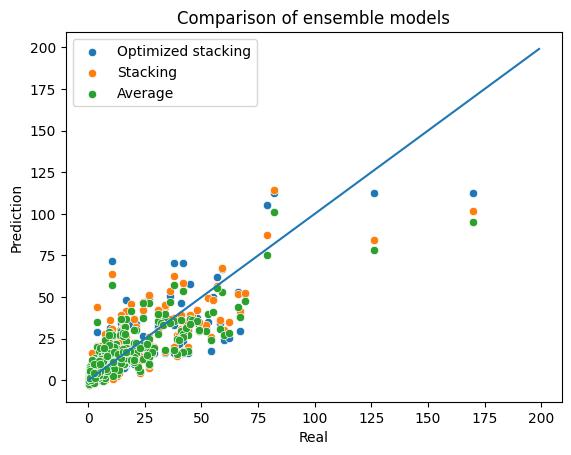

In [92]:
# @title Comparison of predictions
sns.scatterplot(x=y_test, y=y_pred, label='Optimized stacking')
sns.scatterplot(x=y_test, y=stacking_y_pred, label='Stacking')
sns.scatterplot(x=y_test, y=average_series, label='Average')

x_values = range(0,200)
y_values = x_values
plt.plot(x_values, y_values)
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.legend()
plt.title('Comparison of ensemble models')
plt.show()

Notice how each of the 3 models behaves differently than the others but consistently in other situations